### Loading the dataset from the csv file

In [1]:
import pandas as pd

df = pd.read_csv("cleaned_lower_politifact.csv", ',')
X = df['text'].values
labels = df['label'].values

### Data Processing — convert to lower case and remove punctuation

In [2]:
# import re, string

# for i in range(X.size):
    
#     words = X[i].split()
#     filtered_list = []
#     for word in words:
#         pattern = re.compile('[^\u0000-\u007F]+', re.UNICODE)  #Remove all non-alphanumeric characters
        
#         word = pattern.sub('', word)
#         word = word.translate(str.maketrans('', '', string.punctuation))
#         word = word.lower()

#         filtered_list.append(word)
#         result = ' '.join(filtered_list)
        
#     X[i] = result      

# list1 = [['id', 'text', 'label']]
# for i in range(0, len(X)):
#       list1.append([df['id'][i], X[i], df['label'][i]])
# df1 = pd.DataFrame(list1)
# df1.to_csv('cleaned_lower_politifact.csv',sep=',',index = False ,header = False)

### Tokenize — Create Vocab to Int mapping dictionary

Ιn most of the NLP tasks, you will create an index mapping dictionary in such a way that your frequently occurring words are assigned lower indexes. One of the most common way of doing this is to use ```Counter``` method from ```Collections``` library.

In [3]:
from collections import Counter

words_list = []
articles_list = []
for i in range(X.size):
    
    articles_list.append(X[i])
    words = X[i].split()
    words_list.append(words)

flat_words_list = [item for sublist in words_list for item in sublist]
count_words = Counter(flat_words_list)

total_words = len(flat_words_list)
sorted_words = count_words.most_common(total_words)
#print(count_words)
#print(total_words)
#print(sorted_words)

In order to create a vocab to int mapping dictionary, you would simply do this

In [4]:
vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}

There is a small trick here, in this mapping index will start from 0 i.e. mapping of ‘the’ will be 0. But later on we are going to do padding for shorter reviews and conventional choice for padding is 0. So we need to start this indexing from 1

In [5]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

### Tokenize — Encode the words

So far we have created a) list of reviews and b) index mapping dictionary using vocab from all our reviews. All this was to create an encoding of reviews (replace words in our reviews by integers)

In [6]:
articles_int = []
for aricle in articles_list:
    a = [vocab_to_int[w] for w in aricle.split()]
    articles_int.append(a)
print (articles_int[:2])

[[673, 13, 18, 10064, 759, 2, 36, 5, 335, 16, 26, 272, 8207, 1593, 1117, 127, 11, 129, 912, 63, 144, 138, 9000, 49, 496, 2429, 209, 120, 3, 1967, 419, 44, 2555, 2517, 11510, 72, 32, 364, 2, 2133, 3502, 513, 13815, 78, 8, 3144, 171, 4808, 61, 24, 154, 1, 92, 8, 6983, 331, 737, 3, 5, 5819, 726, 4, 441, 78, 13816, 2133, 4097, 2381, 10065, 2, 11511, 1, 172, 6156, 3, 1, 1854, 1930, 1477, 331, 737, 17, 5, 187, 4, 46, 7537, 166, 37, 5820, 1995, 4, 1665, 11512, 4, 1, 1246, 491, 13815, 11513, 18208, 18209, 48, 64, 44, 180, 60, 2517, 6, 1045, 5, 181, 43, 130, 28, 1665, 11512, 13, 51, 18, 2049, 27, 1259, 6, 15, 1478, 9001, 8, 1067, 2, 46, 6157, 1359, 4, 5, 147, 610, 619, 62, 7538, 1338, 4, 3812, 1125, 10066, 472, 1, 135, 18210, 35, 53, 3614, 1322, 37, 1593, 7, 1, 639, 4, 2049, 1, 6157, 1359, 2134, 42, 248, 344, 5821, 62, 993, 3, 43, 5526, 13817, 210, 1576, 6158, 117, 5, 13818, 1360, 394, 13, 8, 20, 5, 13819, 2024, 6, 86, 2518, 6158, 36, 32, 20, 46, 2024, 6, 24, 30, 7539, 2, 1, 1385, 3, 43, 659, 4

Note: what we have created now is a list of lists. Each individual review is a list of integer values and all of them are stored in one huge list

### Analyze Article Length

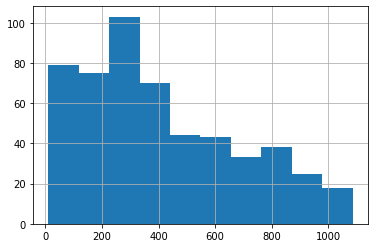

count     528.000000
mean      410.003788
std       276.342183
min        10.000000
25%       205.500000
50%       341.000000
75%       605.000000
max      1087.000000
dtype: float64

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

articles_len = [len(x) for x in articles_int]
pd.Series(articles_len).hist()
plt.show()
pd.Series(articles_len).describe()

__Observations__ :

1. Mean article length = __1538__
2. Most of the articles are around 1000 words or more
3. There are quite a few articles that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis

### Removing Outliers — Getting rid of extremely long or short reviews

In [10]:
articles_int = [ articles_int[i] for i, l in enumerate(articles_len) if l<1100 ]
print(len(labels))

labels = [ labels[i] for i, l in enumerate(articles_len) if l<1100 ]
print(len(labels))

528
528


### Analyze Article Length (after removing outliers)

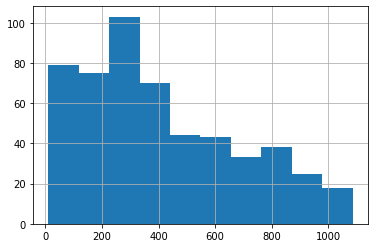

count     528.000000
mean      410.003788
std       276.342183
min        10.000000
25%       205.500000
50%       341.000000
75%       605.000000
max      1087.000000
dtype: float64

In [11]:

articles_len = [len(x) for x in articles_int]
pd.Series(articles_len).hist()
plt.show()
pd.Series(articles_len).describe()

### Padding / Truncating the remaining data

To deal with both short and long articles, we will pad or truncate all our articles to a specific length. We define this length by __Sequence Length__. This sequence length is same as number of time steps for LSTM layer.

For articles shorter than __seq_length__, we will pad with 0s. For articles longer than __seq_length__ we will truncate them to the first seq_length words.

In [16]:
import numpy as np

def pad_features(articles_int, seq_length):

    ''' Return features of articles_int, where each article is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(articles_int), seq_length), dtype = int)
    
    for i, article in enumerate(articles_int):
        article_len = len(article)
        
        if article_len <= seq_length:
            zeroes = list(np.zeros(seq_length-article_len))
            new = zeroes + article
        elif article_len > seq_length:
            new = article[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

Note: We are creating/maintaining a 2D array structure as we created for articles_int. Output will look like this

In [20]:
features = pad_features(articles_int, 1000)

### Training, Validation, Test Dataset Split

Once we have got our data in nice shape, we will split it into training, validation and test sets

train= 80% | valid = 10% | test = 10%

In [24]:
split_frac = 0.8
train_x = features[0 : int(split_frac * len(features))]
train_y = labels[0 : int(split_frac * len(features))]
remaining_x = features[int(split_frac * len(features)) :]
remaining_y = labels[int(split_frac * len(features)) :]
valid_x = remaining_x[0 : int(len(remaining_x) * 0.5)]
valid_y = remaining_y[0 : int(len(remaining_y) * 0.5)]
test_x = remaining_x[int(len(remaining_x) * 0.5) :]
test_y = remaining_y[int(len(remaining_y) * 0.5) :]

### Dataloaders and Batching

After creating our training, test and validation data. Next step is to create dataloaders for this data. We can use generator function for batching our data into batches instead we will use a TensorDataset. This is one of a very useful utility in <u>__PyTorch__</u> for using our data with <u>__DataLoaders__</u> with exact same ease as of  <u>__torchvision datasets__</u> 

In [30]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(train_x)), torch.from_numpy(np.array(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.array(valid_x)), torch.from_numpy(np.array(valid_y)))
test_data = TensorDataset(torch.from_numpy(np.array(test_x)), torch.from_numpy(np.array(test_y)))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)